In [ ]:
%env  WORKDIR=/tmp/vault

In [ ]:
%%bash
cat ${WORKDIR}/cluster-keys.json | jq -r ".root_token"

In [ ]:
%env VAULT_ADDR=https://127.0.0.1:8200
%env VAULT_TOKEN=hvs.ywrc2Nb0iXKHs9xgzmeAnhpN
%env VAULT_CACERT=/tmp/vault/vault.ca
# %env VAULT_NAMESPACE=admin #Enable if using HCP

In [ ]:
%%bash
vault secrets list -detailed

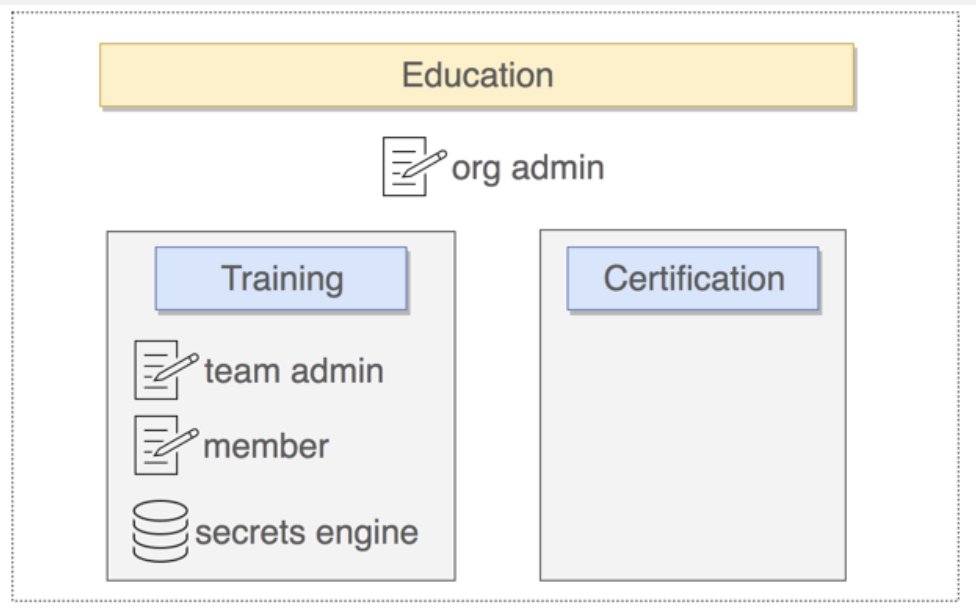

In [ ]:
%%bash
# Root user crea child  namespace
vault namespace create education

# Root crea una policy para generar usuarios admin en el namespace
cat >  $WORKDIR/edu-admin.hcl <<EOF
# Manage namespaces
path "sys/namespaces/*" {
   capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}

# Manage policies
path "sys/policies/acl/*" {
   capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}

# List policies
path "sys/policies/acl" {
   capabilities = ["list"]
}

# Enable and manage secrets engines
path "sys/mounts/*" {
   capabilities = ["create", "read", "update", "delete", "list"]
}

# List available secrets engines
path "sys/mounts" {
  capabilities = [ "read" ]
}

# Create and manage entities and groups
path "identity/*" {
   capabilities = ["create", "read", "update", "delete", "list"]
}

# Manage tokens
path "auth/token/*" {
   capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}
# Mange token en child
path "+/auth/token/*" {
   capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}

# Manage secrets at 'edu-secret'
path "edu-secret/*" {
   capabilities = ["create", "read", "update", "delete", "list"]
}
EOF

# Asocio política al child namespace
vault policy write -namespace=education edu-admin $WORKDIR/edu-admin.hcl

# Creo token con permisos en namespace education para el administrador del namespace
vault token create -policy=edu-admin -orphan -namespace=education -format=json | jq -r .auth.client_token > namespace_admin_token.txt

# Me logueo a Vault usando el token del administrador de namespace del paso previo
export VAULT_TOKEN=$(cat namespace_admin_token.txt)

# Namespace Admin crea child namespace
vault namespace create -namespace=education training

# Creo política para usuario consumidor en nested namespace
cat >  $WORKDIR/training-admin.hcl <<EOF
# Manage namespaces
path "sys/namespaces/*" {
   capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}

# Manage policies
path "sys/policies/acl/*" {
   capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}

# List policies
path "sys/policies/acl" {
  capabilities = ["list"]
}

# Enable and manage secrets engines
path "sys/mounts/*" {
   capabilities = ["create", "read", "update", "delete", "list"]
}

# List available secrets engines
path "sys/mounts" {
  capabilities = [ "read" ]
}

# Manage secrets at 'team-secret'
path "team-secret/*" {
   capabilities = ["create", "read", "update", "delete", "list"]
}
EOF

# Creo un nuevo token para usuario consumidor en el nested namespace
export VAULT_NAMESPACE="education/training" #Defino el namespace donde crear el token
vault token create -policy=training-admin -orphan -format=json | jq -r .auth.client_token > namespace_child_token.txt

echo 'Child namespace consumer token'
cat namespace_child_token.txt
#-----
# Me logueo a Vault usando el último token generado
export VAULT_TOKEN=$(cat namespace_child_token.txt)
export VAULT_NAMESPACE="education/training"
vault token lookup


# Me logueo a Vault usando el último token generado sin definir el namespace
export VAULT_TOKEN=$(cat namespace_child_token.txt)
unset VAULT_NAMESPACE
echo 'Sin variable de namespace'
vault token lookup
